In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-17 17:09:54.320066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 17:10:13.041668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-17 17:10:13.043589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-alphabet.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-alphabet/asl-alphabet"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.6, 0.2, 0.2))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-17 17:10:31.177503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-17 17:10:32.003237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-17 17:10:32.006755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 44695 images belonging to 24 classes.
Found 14892 images belonging to 24 classes.
Found 14921 images belonging to 24 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-17 17:10:39.493533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 17:10:39.511819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-17 17:10:39.515184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-17 17:10:39.518027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

574710816/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [11]:
##DEFINIMOS EL MODELO
num_classes = 24
epochs = 125

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

80134624/80134624 [==============================] - 0s 0us/step
22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

metric = 'val_accuracy'

checkpointer = ModelCheckpoint(filepath='model-05', verbose=1, save_best_only=True,
                               monitor = metric, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, validation_data = valid_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/125


2023-09-17 17:11:13.729669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-17 17:11:48.196913: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55e8620ce270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-17 17:11:48.196968: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-17 17:11:51.690606: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


699/699 [==============================] - ETA: 0s - loss: 7.9206 - accuracy: 0.1522
Epoch 1: val_accuracy improved from -inf to 0.45004, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 184s 180ms/step - loss: 7.9206 - accuracy: 0.1522 - val_loss: 6.8562 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 2/125
699/699 [==============================] - ETA: 0s - loss: 6.4589 - accuracy: 0.5258
Epoch 2: val_accuracy improved from 0.45004 to 0.70488, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 121s 173ms/step - loss: 6.4589 - accuracy: 0.5258 - val_loss: 5.8217 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 3/125
699/699 [==============================] - ETA: 0s - loss: 5.6761 - accuracy: 0.7220
Epoch 3: val_accuracy improved from 0.70488 to 0.79922, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 120s 171ms/step - loss: 5.6761 - accuracy: 0.7220 - val_loss: 5.3760 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 4/125
699/699 [==============================] - ETA: 0s - loss: 5.3004 - accuracy: 0.7952
Epoch 4: val_accuracy improved from 0.79922 to 0.85690, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 119s 170ms/step - loss: 5.3004 - accuracy: 0.7952 - val_loss: 5.0585 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 5/125
699/699 [==============================] - ETA: 0s - loss: 5.0438 - accuracy: 0.8372
Epoch 5: val_accuracy improved from 0.85690 to 0.88282, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 118s 169ms/step - loss: 5.0438 - accuracy: 0.8372 - val_loss: 4.8570 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 6/125
699/699 [==============================] - ETA: 0s - loss: 4.8406 - accuracy: 0.8621
Epoch 6: val_accuracy improved from 0.88282 to 0.89699, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 119s 170ms/step - loss: 4.8406 - accuracy: 0.8621 - val_loss: 4.6758 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 7/125
699/699 [==============================] - ETA: 0s - loss: 4.6621 - accuracy: 0.8807
Epoch 7: val_accuracy did not improve from 0.89699
699/699 [==============================] - 114s 163ms/step - loss: 4.6621 - accuracy: 0.8807 - val_loss: 4.5576 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 8/125
699/699 [==============================] - ETA: 0s - loss: 4.5008 - accuracy: 0.8937
Epoch 8: val_accuracy improved from 0.89699 to 0.91284, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 118s 169ms/step - loss: 4.5008 - accuracy: 0.8937 - val_loss: 4.3908 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 9/125
699/699 [==============================] - ETA: 0s - loss: 4.3562 - accuracy: 0.9030
Epoch 9: val_accuracy improved from 0.91284 to 0.92184, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 118s 169ms/step - loss: 4.3562 - accuracy: 0.9030 - val_loss: 4.2448 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 10/125
699/699 [==============================] - ETA: 0s - loss: 4.2170 - accuracy: 0.9120
Epoch 10: val_accuracy improved from 0.92184 to 0.92855, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 119s 170ms/step - loss: 4.2170 - accuracy: 0.9120 - val_loss: 4.1148 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 11/125
699/699 [==============================] - ETA: 0s - loss: 4.0894 - accuracy: 0.9185
Epoch 11: val_accuracy improved from 0.92855 to 0.93668, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 119s 170ms/step - loss: 4.0894 - accuracy: 0.9185 - val_loss: 3.9929 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 12/125
699/699 [==============================] - ETA: 0s - loss: 3.9663 - accuracy: 0.9238
Epoch 12: val_accuracy improved from 0.93668 to 0.93742, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 119s 170ms/step - loss: 3.9663 - accuracy: 0.9238 - val_loss: 3.8795 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 13/125
699/699 [==============================] - ETA: 0s - loss: 3.8514 - accuracy: 0.9284
Epoch 13: val_accuracy improved from 0.93742 to 0.94480, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 118s 169ms/step - loss: 3.8514 - accuracy: 0.9284 - val_loss: 3.7579 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 14/125
699/699 [==============================] - ETA: 0s - loss: 3.7365 - accuracy: 0.9337
Epoch 14: val_accuracy did not improve from 0.94480
699/699 [==============================] - 113s 162ms/step - loss: 3.7365 - accuracy: 0.9337 - val_loss: 3.6592 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 15/125
699/699 [==============================] - ETA: 0s - loss: 3.6297 - accuracy: 0.9365
Epoch 15: val_accuracy improved from 0.94480 to 0.95004, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 118s 168ms/step - loss: 3.6297 - accuracy: 0.9365 - val_loss: 3.5423 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 16/125
699/699 [==============================] - ETA: 0s - loss: 3.5278 - accuracy: 0.9397
Epoch 16: val_accuracy improved from 0.95004 to 0.95185, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 118s 168ms/step - loss: 3.5278 - accuracy: 0.9397 - val_loss: 3.4437 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 17/125
699/699 [==============================] - ETA: 0s - loss: 3.4289 - accuracy: 0.9423
Epoch 17: val_accuracy improved from 0.95185 to 0.95830, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 117s 168ms/step - loss: 3.4289 - accuracy: 0.9423 - val_loss: 3.3352 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 18/125
699/699 [==============================] - ETA: 0s - loss: 3.3244 - accuracy: 0.9459
Epoch 18: val_accuracy did not improve from 0.95830
699/699 [==============================] - 113s 161ms/step - loss: 3.3244 - accuracy: 0.9459 - val_loss: 3.2686 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 19/125
699/699 [==============================] - ETA: 0s - loss: 3.2364 - accuracy: 0.9477
Epoch 19: val_accuracy did not improve from 0.95830
699/699 [==============================] - 112s 160ms/step - loss: 3.2364 - accuracy: 0.9477 - val_loss: 3.1718 - val_accuracy: 0.9555 - lr: 0.0010
Epoch 20/125
699/699 [==============================] - ETA: 0s - loss: 3.1409 - accuracy: 0.9518
Epoch 20: val_accuracy improved from 0.95830 to 0.96125, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 119s 170ms/step - loss: 3.1409 - accuracy: 0.9518 - val_loss: 3.0705 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 21/125
699/699 [==============================] - ETA: 0s - loss: 3.0524 - accuracy: 0.9529
Epoch 21: val_accuracy improved from 0.96125 to 0.96421, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 117s 168ms/step - loss: 3.0524 - accuracy: 0.9529 - val_loss: 2.9826 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 22/125
699/699 [==============================] - ETA: 0s - loss: 2.9709 - accuracy: 0.9529
Epoch 22: val_accuracy did not improve from 0.96421
699/699 [==============================] - 113s 161ms/step - loss: 2.9709 - accuracy: 0.9529 - val_loss: 2.9150 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 23/125
699/699 [==============================] - ETA: 0s - loss: 2.8872 - accuracy: 0.9546
Epoch 23: val_accuracy did not improve from 0.96421
699/699 [==============================] - 112s 160ms/step - loss: 2.8872 - accuracy: 0.9546 - val_loss: 2.8410 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 24/125
699/699 [==============================] - ETA: 0s - loss: 2.8079 - accuracy: 0.9562
Epoch 24: val_accuracy did not improve from 0.96421
699/699 [==============================] - 112s 160ms/step - loss: 2.8079 - accuracy: 0.9562 - val_loss: 2

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 117s 168ms/step - loss: 2.7311 - accuracy: 0.9568 - val_loss: 2.6696 - val_accuracy: 0.9659 - lr: 0.0010
Epoch 26/125
699/699 [==============================] - ETA: 0s - loss: 2.6554 - accuracy: 0.9595
Epoch 26: val_accuracy did not improve from 0.96589
699/699 [==============================] - 112s 160ms/step - loss: 2.6554 - accuracy: 0.9595 - val_loss: 2.6017 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 27/125
699/699 [==============================] - ETA: 0s - loss: 2.5815 - accuracy: 0.9603
Epoch 27: val_accuracy did not improve from 0.96589
699/699 [==============================] - 112s 160ms/step - loss: 2.5815 - accuracy: 0.9603 - val_loss: 2.5559 - val_accuracy: 0.9568 - lr: 0.0010
Epoch 28/125
699/699 [==============================] - ETA: 0s - loss: 2.5112 - accuracy: 0.9616
Epoch 28: val_accuracy improved from 0.96589 to 0.96609, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 117s 168ms/step - loss: 2.5112 - accuracy: 0.9616 - val_loss: 2.4626 - val_accuracy: 0.9661 - lr: 0.0010
Epoch 29/125
699/699 [==============================] - ETA: 0s - loss: 2.4436 - accuracy: 0.9627
Epoch 29: val_accuracy did not improve from 0.96609
699/699 [==============================] - 111s 159ms/step - loss: 2.4436 - accuracy: 0.9627 - val_loss: 2.4030 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 30/125
699/699 [==============================] - ETA: 0s - loss: 2.3718 - accuracy: 0.9638
Epoch 30: val_accuracy improved from 0.96609 to 0.96992, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 116s 166ms/step - loss: 2.3718 - accuracy: 0.9638 - val_loss: 2.3255 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 31/125
699/699 [==============================] - ETA: 0s - loss: 2.3126 - accuracy: 0.9642
Epoch 31: val_accuracy did not improve from 0.96992
699/699 [==============================] - 112s 160ms/step - loss: 2.3126 - accuracy: 0.9642 - val_loss: 2.2693 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 32/125
699/699 [==============================] - ETA: 0s - loss: 2.2499 - accuracy: 0.9636
Epoch 32: val_accuracy improved from 0.96992 to 0.97133, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 117s 167ms/step - loss: 2.2499 - accuracy: 0.9636 - val_loss: 2.1963 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 33/125
699/699 [==============================] - ETA: 0s - loss: 2.1877 - accuracy: 0.9656
Epoch 33: val_accuracy did not improve from 0.97133
699/699 [==============================] - 112s 160ms/step - loss: 2.1877 - accuracy: 0.9656 - val_loss: 2.1488 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 34/125
699/699 [==============================] - ETA: 0s - loss: 2.1273 - accuracy: 0.9660
Epoch 34: val_accuracy improved from 0.97133 to 0.97307, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 116s 166ms/step - loss: 2.1273 - accuracy: 0.9660 - val_loss: 2.0795 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 35/125
699/699 [==============================] - ETA: 0s - loss: 2.0696 - accuracy: 0.9670
Epoch 35: val_accuracy improved from 0.97307 to 0.97415, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 115s 165ms/step - loss: 2.0696 - accuracy: 0.9670 - val_loss: 2.0249 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 36/125
699/699 [==============================] - ETA: 0s - loss: 2.0120 - accuracy: 0.9687
Epoch 36: val_accuracy improved from 0.97415 to 0.97455, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 116s 166ms/step - loss: 2.0120 - accuracy: 0.9687 - val_loss: 1.9684 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 37/125
699/699 [==============================] - ETA: 0s - loss: 1.9612 - accuracy: 0.9685
Epoch 37: val_accuracy did not improve from 0.97455
699/699 [==============================] - 111s 159ms/step - loss: 1.9612 - accuracy: 0.9685 - val_loss: 1.9219 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 38/125
699/699 [==============================] - ETA: 0s - loss: 1.9064 - accuracy: 0.9700
Epoch 38: val_accuracy did not improve from 0.97455
699/699 [==============================] - 111s 159ms/step - loss: 1.9064 - accuracy: 0.9700 - val_loss: 1.8669 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 39/125
699/699 [==============================] - ETA: 0s - loss: 1.8525 - accuracy: 0.9709
Epoch 39: val_accuracy did not improve from 0.97455
699/699 [==============================] - 111s 159ms/step - loss: 1.8525 - accuracy: 0.9709 - val_loss: 1

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 115s 164ms/step - loss: 1.7100 - accuracy: 0.9714 - val_loss: 1.6724 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 43/125
699/699 [==============================] - ETA: 0s - loss: 1.6612 - accuracy: 0.9730
Epoch 43: val_accuracy did not improve from 0.97690
699/699 [==============================] - 110s 157ms/step - loss: 1.6612 - accuracy: 0.9730 - val_loss: 1.6373 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 44/125
699/699 [==============================] - ETA: 0s - loss: 1.6186 - accuracy: 0.9729
Epoch 44: val_accuracy did not improve from 0.97690
699/699 [==============================] - 111s 158ms/step - loss: 1.6186 - accuracy: 0.9729 - val_loss: 1.5930 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 45/125
699/699 [==============================] - ETA: 0s - loss: 1.5732 - accuracy: 0.9735
Epoch 45: val_accuracy did not improve from 0.97690
699/699 [==============================] - 111s 158ms/step - loss: 1.5732 - accuracy: 0.9735 - val_loss: 1

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 115s 164ms/step - loss: 1.4525 - accuracy: 0.9742 - val_loss: 1.4250 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 49/125
699/699 [==============================] - ETA: 0s - loss: 1.4107 - accuracy: 0.9758
Epoch 49: val_accuracy improved from 0.97811 to 0.97838, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 116s 165ms/step - loss: 1.4107 - accuracy: 0.9758 - val_loss: 1.3854 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 50/125
699/699 [==============================] - ETA: 0s - loss: 1.3730 - accuracy: 0.9761
Epoch 50: val_accuracy improved from 0.97838 to 0.97858, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 114s 164ms/step - loss: 1.3730 - accuracy: 0.9761 - val_loss: 1.3470 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 51/125
699/699 [==============================] - ETA: 0s - loss: 1.3351 - accuracy: 0.9772
Epoch 51: val_accuracy improved from 0.97858 to 0.97938, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 115s 165ms/step - loss: 1.3351 - accuracy: 0.9772 - val_loss: 1.3085 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 52/125
699/699 [==============================] - ETA: 0s - loss: 1.3016 - accuracy: 0.9765
Epoch 52: val_accuracy improved from 0.97938 to 0.97992, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 115s 164ms/step - loss: 1.3016 - accuracy: 0.9765 - val_loss: 1.2738 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 53/125
699/699 [==============================] - ETA: 0s - loss: 1.2681 - accuracy: 0.9764
Epoch 53: val_accuracy improved from 0.97992 to 0.98113, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 114s 163ms/step - loss: 1.2681 - accuracy: 0.9764 - val_loss: 1.2405 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 54/125
699/699 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.9770
Epoch 54: val_accuracy did not improve from 0.98113
699/699 [==============================] - 109s 156ms/step - loss: 1.2351 - accuracy: 0.9770 - val_loss: 1.2182 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 55/125
699/699 [==============================] - ETA: 0s - loss: 1.2022 - accuracy: 0.9775
Epoch 55: val_accuracy did not improve from 0.98113
699/699 [==============================] - 109s 156ms/step - loss: 1.2022 - accuracy: 0.9775 - val_loss: 1.1825 - val_accuracy: 0.9782 - lr: 0.0010
Epoch 56/125
699/699 [==============================] - ETA: 0s - loss: 1.1688 - accuracy: 0.9781
Epoch 56: val_accuracy did not improve from 0.98113
699/699 [==============================] - 110s 157ms/step - loss: 1.1688 - accuracy: 0.9781 - val_loss: 1

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 114s 163ms/step - loss: 1.0793 - accuracy: 0.9784 - val_loss: 1.0568 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 60/125
699/699 [==============================] - ETA: 0s - loss: 1.0506 - accuracy: 0.9781
Epoch 60: val_accuracy did not improve from 0.98288
699/699 [==============================] - 109s 155ms/step - loss: 1.0506 - accuracy: 0.9781 - val_loss: 1.0235 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 61/125
699/699 [==============================] - ETA: 0s - loss: 1.0233 - accuracy: 0.9785
Epoch 61: val_accuracy improved from 0.98288 to 0.98422, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 114s 163ms/step - loss: 1.0233 - accuracy: 0.9785 - val_loss: 0.9987 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 62/125
699/699 [==============================] - ETA: 0s - loss: 0.9967 - accuracy: 0.9798
Epoch 62: val_accuracy did not improve from 0.98422
699/699 [==============================] - 109s 156ms/step - loss: 0.9967 - accuracy: 0.9798 - val_loss: 0.9765 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 63/125
699/699 [==============================] - ETA: 0s - loss: 0.9707 - accuracy: 0.9793
Epoch 63: val_accuracy did not improve from 0.98422
699/699 [==============================] - 110s 157ms/step - loss: 0.9707 - accuracy: 0.9793 - val_loss: 0.9516 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 64/125
699/699 [==============================] - ETA: 0s - loss: 0.9432 - accuracy: 0.9806
Epoch 64: val_accuracy did not improve from 0.98422
699/699 [==============================] - 109s 156ms/step - loss: 0.9432 - accuracy: 0.9806 - val_loss: 0

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 113s 161ms/step - loss: 0.7627 - accuracy: 0.9819 - val_loss: 0.7417 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 73/125
699/699 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.9820
Epoch 73: val_accuracy did not improve from 0.98664
699/699 [==============================] - 110s 157ms/step - loss: 0.7441 - accuracy: 0.9820 - val_loss: 0.7324 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 74/125
699/699 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.9816
Epoch 74: val_accuracy did not improve from 0.98664
699/699 [==============================] - 110s 157ms/step - loss: 0.7260 - accuracy: 0.9816 - val_loss: 0.7128 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 75/125
699/699 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.9821
Epoch 75: val_accuracy did not improve from 0.98664
699/699 [==============================] - 109s 156ms/step - loss: 0.7082 - accuracy: 0.9821 - val_loss: 0

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 113s 162ms/step - loss: 0.3917 - accuracy: 0.9854 - val_loss: 0.3836 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 99/125
699/699 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.9855
Epoch 99: val_accuracy did not improve from 0.98670
699/699 [==============================] - 110s 158ms/step - loss: 0.3830 - accuracy: 0.9855 - val_loss: 0.3765 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 100/125
699/699 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.9859
Epoch 100: val_accuracy did not improve from 0.98670
699/699 [==============================] - 111s 158ms/step - loss: 0.3707 - accuracy: 0.9859 - val_loss: 0.3706 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 101/125
699/699 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.9856
Epoch 101: val_accuracy improved from 0.98670 to 0.98697, saving model to model-05


INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 114s 163ms/step - loss: 0.3635 - accuracy: 0.9856 - val_loss: 0.3554 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 102/125
698/699 [============================>.] - ETA: 0s - loss: 0.3532 - accuracy: 0.9868
Epoch 102: val_accuracy did not improve from 0.98697
699/699 [==============================] - 109s 157ms/step - loss: 0.3533 - accuracy: 0.9868 - val_loss: 0.3586 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 103/125
699/699 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.9858
Epoch 103: val_accuracy did not improve from 0.98697
699/699 [==============================] - 109s 155ms/step - loss: 0.3457 - accuracy: 0.9858 - val_loss: 0.3437 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 104/125
699/699 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.9867
Epoch 104: val_accuracy did not improve from 0.98697
699/699 [==============================] - 109s 156ms/step - loss: 0.3364 - accuracy: 0.9867 - val_l

INFO:tensorflow:Assets written to: model-05/assets


INFO:tensorflow:Assets written to: model-05/assets


699/699 [==============================] - 113s 162ms/step - loss: 0.2789 - accuracy: 0.9866 - val_loss: 0.2759 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 113/125
699/699 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9866
Epoch 113: val_accuracy did not improve from 0.98852
699/699 [==============================] - 109s 156ms/step - loss: 0.2711 - accuracy: 0.9866 - val_loss: 0.2714 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 114/125
699/699 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9879
Epoch 114: val_accuracy did not improve from 0.98852
699/699 [==============================] - 109s 156ms/step - loss: 0.2621 - accuracy: 0.9879 - val_loss: 0.2605 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 115/125
699/699 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9866
Epoch 115: val_accuracy did not improve from 0.98852
699/699 [==============================] - 110s 158ms/step - loss: 0.2590 - accuracy: 0.9866 - val_l

In [13]:
preds_test = model.predict(test_generator)

234/234 [==============================] - 28s 120ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

234/234 [==============================] - 28s 118ms/step - loss: 0.2133 - accuracy: 0.9854


In [15]:
evaluate_test

[0.21334142982959747, 0.9853897094726562]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 0,  0,  0, ..., 23, 23, 23])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9864620333757791

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[614,   2,   0,   0,   1,   0,   0,   0,   0,   0,   1,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0, 620,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0],
       [  1,   1, 625,   2,   0,   0,   0,   0,   0,   0,   1,   0,   0,
          1,   0,   1,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0, 616,   2,   0,   0,   0,   1,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   3,   0,   2, 629,   0,   0,   0,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0, 621,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0, 617,   0,   1,   0,   1,   0,   0,
          0,   1,   1,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,  13

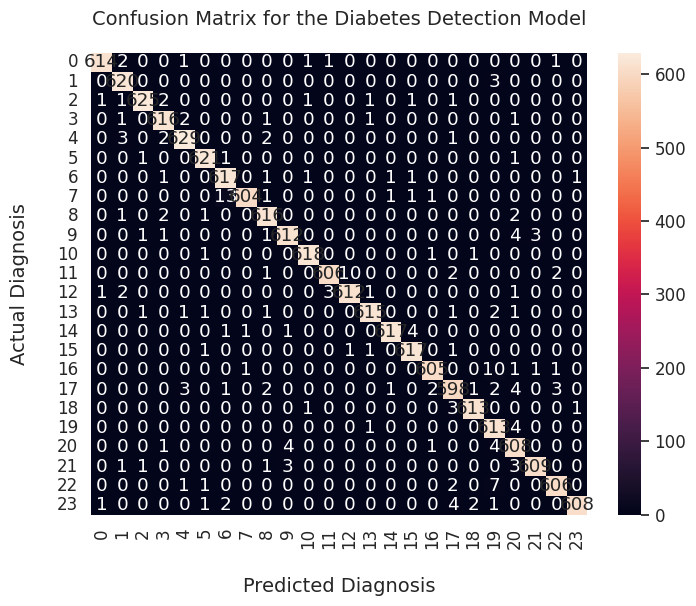

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

233/233 [==============================] - 27s 115ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

233/233 [==============================] - 27s 116ms/step - loss: 0.2076 - accuracy: 0.9865


In [23]:
evaluate_val

[0.20763839781284332, 0.9865028262138367]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 0,  0,  0, ..., 23, 23, 23])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [ ]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9885844748858448

In [ ]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[611,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   1,   1,   0,   0,   0,   2,   0],
       [  0, 620,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2, 626,   0,   0,   1,   1,   0,   0,   0,   1,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0, 617,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0],
       [  0,   2,   0,   0, 630,   0,   0,   0,   2,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 615,   1,   0,   1,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0, 619,   1,   1,   0,   0,   0,   0,
          0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   8

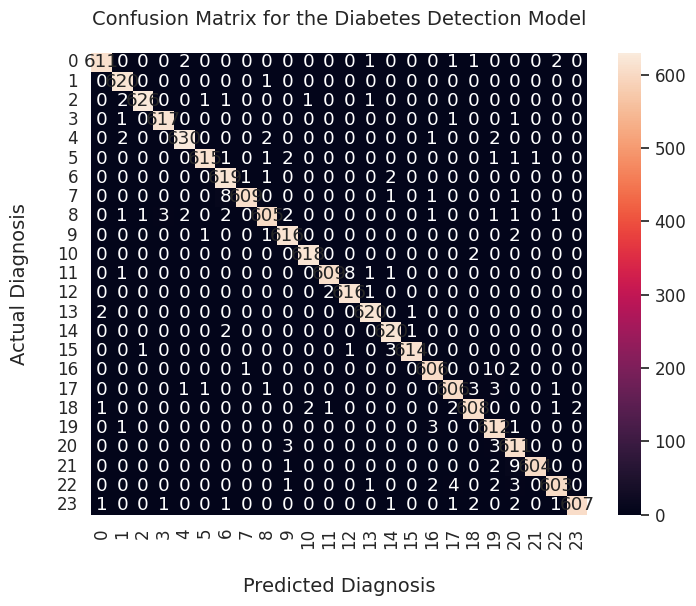

In [ ]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()